<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/breaker_ranking_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/capstone

/content/drive/MyDrive/Github/capstone


In [3]:
%ls

 Capstone.ipynb           pd2.png   __pycache__/                         trivium_scaler.pkl
 data_exploration.ipynb   pd3       README.md                            trivium_scorecard.csv
 pd                       pd3.png  'trivium_full_column_names (1).csv'   Webscraping.xlsx
 pd2                      pd.png    trivium_pca.pkl


In [4]:
!pip install skelo

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone')

In [6]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
import joblib
from sklearn.preprocessing import LabelEncoder
from skelo.model.elo import EloEstimator
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skelo.model.glicko2 import Glicko2Estimator
# import glicko2

In [7]:
#load models if needed
scaler = joblib.load('trivium_scaler.pkl')
pca= joblib.load('trivium_pca.pkl')

In [8]:
#load files
trivium= pd.read_csv('trivium_scorecard.csv')
webscraping = pd.read_excel('Webscraping.xlsx', sheet_name=None)
webscraping.keys()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


dict_keys(['Events and8', 'Events', 'Events WDSF', 'Battles Trivium', 'Battles and8 Threefold', 'Battles and8 Single Slider', 'Battles and8 Round by Round', 'Battles and8 Traditional', 'Research Questions', 'Notes', 'Notes Columns'])

In [9]:
#Load battle winners
#threefold
threefold = webscraping['Battles and8 Threefold']
threefold.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category', 'breaker 1': 'breaker 1 (red)', 'breaker 2': 'breaker 2 (blue)'}, inplace=True)
threefold[['Event', 'Category']] = threefold[['Event', 'Category']].fillna(method='ffill')
#Trivium
trivium=webscraping['Battles Trivium']
trivium.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
trivium[['Event', 'Category']]= trivium[['Event', 'Category']].fillna(method='ffill')
#traditional
traditional = webscraping['Battles and8 Traditional']
traditional.rename(columns={'Unnamed: 0':'Event', 'Unnamed: 1': 'Category'}, inplace=True)
traditional[['Event', 'Category']] = traditional[['Event', 'Category']].fillna(method='ffill')

In [10]:
tr=traditional[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
th=threefold[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()
tv=trivium[['Event', 'Category', 'breaker 1 (red)', 'breaker 2 (blue)', 'winner']].copy()

dataframes = [('traditional', tr), ('threefold', th), ('trivium', tv)]

# Create an empty list to store modified dataframes
appended_dfs = []

# Iterate to create a combined dataframe
for name, dframe in dataframes:
    dframe['Original_DF'] = name
    dframe['Battle_ID'] = dframe.index
    appended_dfs.append(dframe)
appendedBattles = pd.concat(appended_dfs, ignore_index=True)


In [11]:
eventsAnd8=webscraping['Events and8'][1:].copy()
new_header= eventsAnd8.iloc[0]
eventsAnd8=eventsAnd8.drop(1)
eventsAnd8.columns = new_header
eventsAnd8.rename(columns={'Name':'Event'}, inplace=True)
eventsAnd8.drop_duplicates(subset=['Event'], inplace=True)

eventsWDSF = webscraping['Events WDSF'][1:].copy()
new_header = eventsWDSF.iloc[0]
eventsWDSF = eventsWDSF.drop(1)
eventsWDSF.columns = new_header
eventsWDSF.rename(columns={'Name': 'Event'}, inplace=True)
eventsWDSF.drop_duplicates(subset=['Event'], inplace=True)

Events = webscraping['Events'][1:].copy()
new_header = Events.iloc[0]
Events = Events.drop(1)
Events.columns = new_header
Events.rename(columns={'Name':'Event'}, inplace=True)
Events.drop_duplicates(subset=['Event'], inplace=True)

combined_events = pd.concat([eventsAnd8, eventsWDSF, Events], ignore_index=True)

In [12]:
#add battle date
appendedBattles=pd.merge(appendedBattles, combined_events[['Date', 'Event']], on='Event', how='left')
appendedBattles['loser'] = np.where(appendedBattles['winner'] == appendedBattles['breaker 1 (red)'], appendedBattles['breaker 2 (blue)'], appendedBattles['breaker 1 (red)'])
appendedBattles[['winner', 'loser']]=appendedBattles[['winner', 'loser']].astype(str)
battlesNotide=appendedBattles[appendedBattles['winner']!='Tie'].copy()

In [13]:
#Instead of distinguishing between winners and losers, it labels one player as "player1" and the other as "player2"
#and assigns a binary label (1 for player1 winning and 0 for player2 winning).
def load_data(df):
    df["Date"] = pd.to_datetime(df['Date'])
    # labels in the dataset, so we relabel the order of (winner, loser) to just be (player1, player2)
    order_mask = (df["winner"] < df["loser"])
    df["p1"] = ""
    df["p2"] = ""
    df["label"] = 1
    df.loc[order_mask, "p1"] = df.loc[order_mask, "winner"]
    df.loc[~order_mask, "p1"] = df.loc[~order_mask, "loser"]
    df.loc[order_mask, "p2"] = df.loc[order_mask, "loser"]
    df.loc[~order_mask, "p2"] = df.loc[~order_mask, "winner"]
    df.loc[~order_mask, "label"] = 0

    return df

In [14]:
battlesNotide= load_data(battlesNotide)
battlesNotide.head(5)

,Event,Category,breaker 1 (red),breaker 2 (blue),winner,Original_DF,Battle_ID,Date,loser,p1,p2,label
0,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Noé,Noé,traditional,0,2023-07-05,Kidmario,Kidmario,Noé,0
1,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Killian,Killian,traditional,1,2023-07-05,Wilfried,Killian,Wilfried,1
2,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Noé,Noé,traditional,2,2023-07-05,Wilfried,Noé,Wilfried,1
3,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Kidmario,Killian,Killian,traditional,3,2023-07-05,Kidmario,Kidmario,Killian,0
4,Championnat de France 2023,B-Boys +16 Top 16 Round Robin Group D,Wilfried,Kidmario,Wilfried,traditional,4,2023-07-05,Kidmario,Kidmario,Wilfried,0


In [19]:
boys = battlesNotide[(battlesNotide['Category'].str.contains('Boy')) | (battlesNotide['Category'].str.contains('Men'))]
girls= battlesNotide[(battlesNotide['Category'].str.contains('Girl')) | (battlesNotide['Category'].str.contains('Women'))]
others = battlesNotide[~battlesNotide.index.isin(boys.index) & ~battlesNotide.index.isin(girls.index)]

boys.shape[0], girls.shape[0],others.shape[0], battlesNotide.shape[0]== (boys.shape[0]+ girls.shape[0]+others.shape[0])

(1386, 851, 336, True)

In [17]:
girls

,Event,Category,breaker 1 (red),breaker 2 (blue),winner,Original_DF,Battle_ID,Date,loser,p1,p2,label
24,Championnat de France 2023,B-Girls +16 Top 16 Round Robin Group D,Mareva,Zouza,Zouza,traditional,24,2023-07-05,Mareva,Mareva,Zouza,0
25,Championnat de France 2023,B-Girls +16 Top 16 Round Robin Group D,Lily Rose,Carlota,Carlota,traditional,25,2023-07-05,Lily Rose,Carlota,Lily Rose,1
26,Championnat de France 2023,B-Girls +16 Top 16 Round Robin Group D,Lily Rose,Zouza,Zouza,traditional,26,2023-07-05,Lily Rose,Lily Rose,Zouza,0
27,Championnat de France 2023,B-Girls +16 Top 16 Round Robin Group D,Mareva,Carlota,Carlota,traditional,27,2023-07-05,Mareva,Carlota,Mareva,1
28,Championnat de France 2023,B-Girls +16 Top 16 Round Robin Group D,Lily Rose,Mareva,Mareva,traditional,28,2023-07-05,Lily Rose,Lily Rose,Mareva,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2596,WDSF Pan American Qualifier 2017 - Philadelphia,B-Girls Top 4 Round Robin,Connie,Emma,Connie,trivium,1493,2017-06-10,Emma,Connie,Emma,1
2597,WDSF Pan American Qualifier 2017 - Philadelphia,B-Girls Top 4 Round Robin,Esya,Emma,Emma,trivium,1494,2017-06-10,Esya,Emma,Esya,1
2598,WDSF Pan American Qualifier 2017 - Philadelphia,B-Girls Top 4 Round Robin,Esya,Nadjaya,Esya,trivium,1495,2017-06-10,Nadjaya,Esya,Nadjaya,1
2599,WDSF Pan American Qualifier 2017 - Philadelphia,B-Girls Top 4 Round Robin,Nadjaya,Connie,Connie,trivium,1496,2017-06-10,Nadjaya,Connie,Nadjaya,1


In [26]:
def fit_model(X):
    # Extracting required columns
    X_subset = X[['Date', 'p1', 'p2', 'label']]

    # Create an instance of the EloEstimator model
    model = EloEstimator(
        key1_field="p1",
        key2_field="p2",
        timestamp_field="Date",
        initial_time=min(X['Date'])  # Adjust according to your requirement
    )

    # Fit the model
    fitted_model = model.fit(X_subset, X_subset["label"])

    return fitted_model

In [33]:
def plot_top_ratings(ax, ratings_frame, title):
    ts_est = ratings_frame.pivot_table(index='valid_from', columns='key', values='rating').ffill()
    idx = ts_est.iloc[-1].sort_values().index[-5:]
    ts_est.loc[:, idx].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Rating')
    ax.set_title(f'Top 5 Ratings Over Time - {title}')
    ax.legend(title='Player')
    ax.grid(True)

In [27]:
X_boy= boys[['Date', 'p1', 'p2', 'label']]
X_girl= girls[['Date', 'p1', 'p2', 'label']]
X_other= others[['Date', 'p1', 'p2', 'label']]

In [28]:
g_model=fit_model(X_girl)
b_model=fit_model(X_boy)
o_model=fit_model(X_other)

In [46]:
boy_elo_rank= b_model.rating_model.to_frame()
girl_elo_rank=g_model.rating_model.to_frame()
other_elo_rank=o_model.rating_model.to_frame()

In [61]:
boy_elo_current=boy_elo_rank[(boy_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
girl_elo_current = girl_elo_rank[(girl_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')
other_elo_current = other_elo_rank[(other_elo_rank['valid_to'].isnull())].sort_values(by='rating', ascending=False)
other_top10 = other_elo_current[(other_elo_current['valid_from']>= '2023-01-01')].nlargest(10, 'rating')


#get top 10

<ipython-input-61-f6b1ed5a7d06>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  boy_top10=boy_elo_current[(boy_elo_rank['valid_from']>= '2023-01-01')].nlargest(10, 'rating')
<ipython-input-61-f6b1ed5a7d06>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  girl_top10 = girl_elo_current[(girl_elo_rank['valid_from'] >= '2023-01-01')].nlargest(10, 'rating')


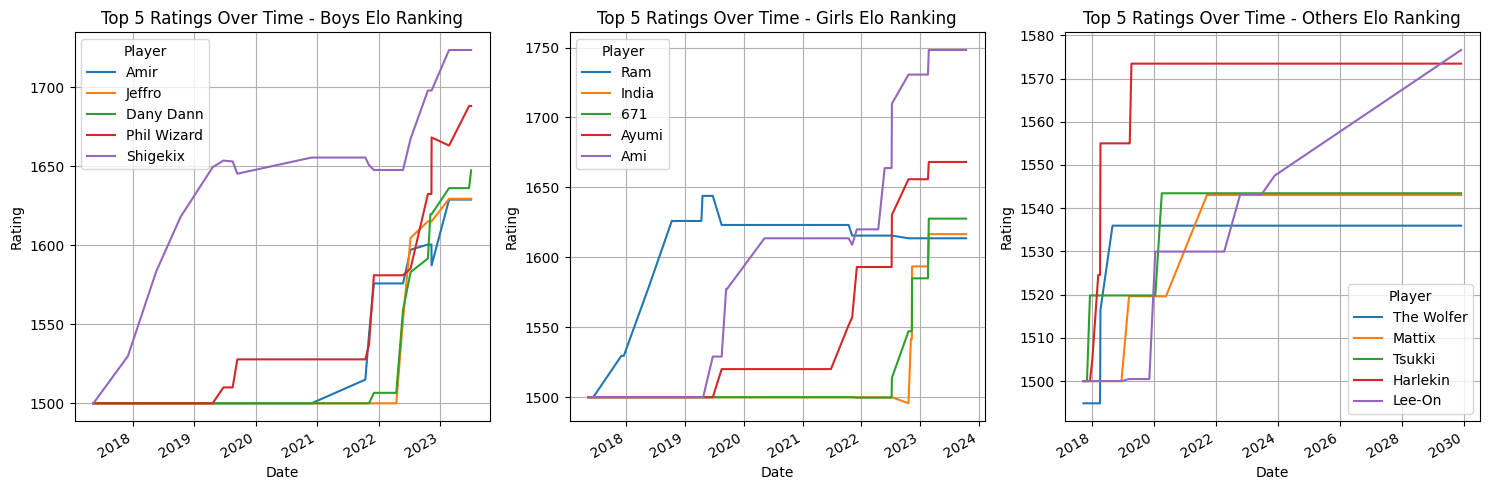

In [69]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each model's top ratings horizontally
plot_top_ratings(axes[0], boy_elo_rank[boy_elo_rank['key'].isin(boy_top10['key'].to_list())], 'Boys Elo Ranking')
plot_top_ratings(axes[1], girl_elo_rank, 'Girls Elo Ranking')
plot_top_ratings(axes[2], other_elo_rank, 'Others Elo Ranking')

# Show plots side by side
plt.tight_layout()
plt.show()

In [68]:
boy_top10['key'].to_list()
boy_elo_rank[boy_elo_rank['key'].isin(boy_top10['key'].to_list())]

,key,rating,valid_from,valid_to
523,Menno,1500.000000,2017-05-11,2019-06-23
524,Menno,1510.287744,2019-06-23,2019-06-23
525,Menno,1519.704478,2019-06-23,2019-06-23
526,Menno,1529.984313,2019-06-23,2019-06-23
527,Menno,1540.347615,2019-06-23,2019-06-23
...,...,...,...,...
2970,Phil Wizard,1673.535209,2023-02-24,2023-06-23
2971,Phil Wizard,1679.237209,2023-06-23,2023-06-23
2972,Phil Wizard,1684.617771,2023-06-23,2023-06-23
2973,Phil Wizard,1691.856025,2023-06-23,2023-06-23


In [ ]:
print(classification_report(X["label"], model.predict(X)))

              precision    recall  f1-score   support

           0       0.56      0.74      0.64      1252
           1       0.64      0.43      0.52      1321

    accuracy                           0.59      2573
   macro avg       0.60      0.59      0.58      2573
weighted avg       0.60      0.59      0.58      2573



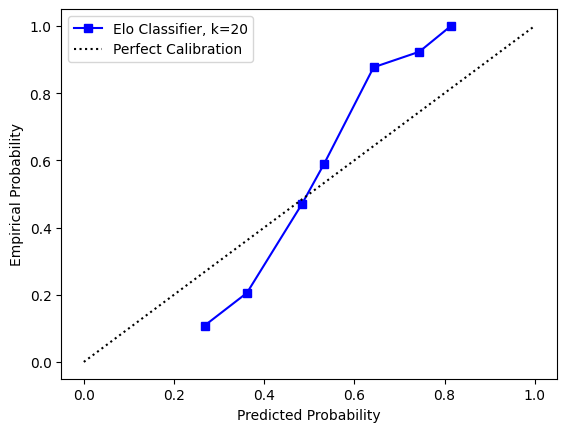

In [ ]:
#Classification Curve
prob_true, prob_pred = calibration_curve(
  X["label"],
  model.predict_proba(X).values[:, 0],
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Elo Classifier, k={model.rating_model.default_k}", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()

Glicko Rating

In [ ]:
modelG = Glicko2Estimator(
  key1_field="p1",
  key2_field="p2",
  timestamp_field="Date",
  initial_time=min(appendedBattles['Date'])
).fit(X, X['label'])

In [ ]:
glicko_cur_ranking=modelG.rating_model.to_frame()
glicko_cur_ranking=glicko_cur_ranking[glicko_cur_ranking['valid_to'].isnull()].sort_values(by='rating', ascending=False)
glicko_cur_ranking

,key,rating,valid_from,valid_to
3544,Victor,"(2360.44468034508, 124.70628683354136, 0.06000...",2022-11-12,NaT
488,Shigekix,"(2141.970061890445, 78.08602917009857, 0.05997...",2023-02-24,NaT
1766,Phil Wizard,"(2135.510404951435, 83.00994159873342, 0.05999...",2023-06-23,NaT
1582,Ami,"(2116.088041932175, 88.13561350707772, 0.05998...",2023-02-24,NaT
3256,Bumblebee,"(2084.5892765037183, 103.10147856411946, 0.059...",2019-09-14,NaT
...,...,...,...,...
4461,Free,"(1062.6594160177788, 191.3951461007818, 0.0599...",2017-12-17,NaT
3562,Marvin,"(1047.0461417257745, 186.0137629319709, 0.0599...",2017-12-17,NaT
809,Minh,"(1035.177400871821, 223.3606679119546, 0.06000...",2023-10-14,NaT
3202,Miimo,"(960.0983098369692, 216.66307172405274, 0.0600...",2021-12-04,NaT


In [ ]:
print(classification_report(X["label"], modelG.predict(X)))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64      1252
           1       0.65      0.44      0.53      1321

    accuracy                           0.59      2573
   macro avg       0.60      0.59      0.58      2573
weighted avg       0.60      0.59      0.58      2573



In [ ]:
if (model.predict(X) == modelG.predict(X)).all():
    print("The columns are identical.")
else:
    print("The columns are not identical.")

The columns are not identical.


<Axes: >

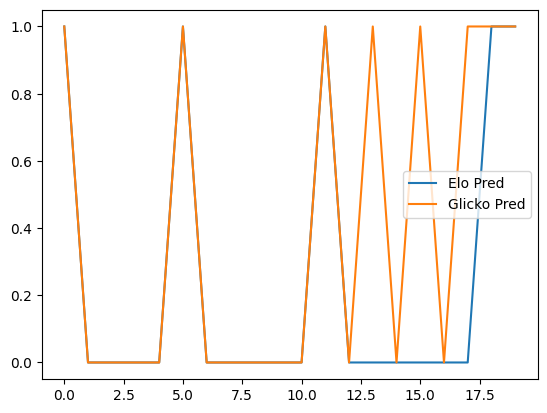

In [ ]:
predictions=pd.concat([model.predict(X), modelG.predict(X)], axis=1)
predictions.columns = ['Elo Pred', 'Glicko Pred']


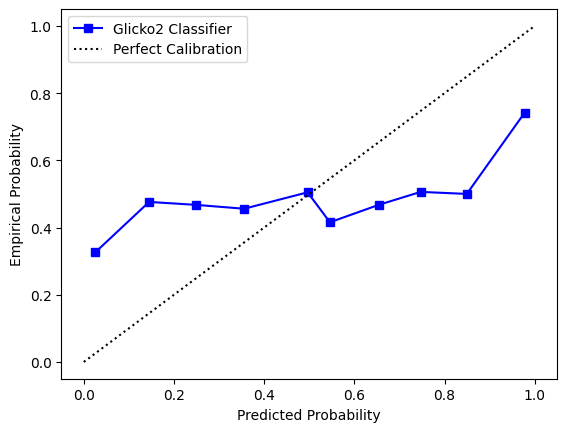

In [ ]:
prob_true, prob_pred = calibration_curve(
  X["label"],
  modelG.predict_proba(X).values[:, 0],
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Glicko2 Classifier", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfect Calibration", ls=":", color='k')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.legend()